Importación y Carga de Datos

In [3]:
# Importaciones correctas
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

df = pd.read_csv('telecom_customer_churn.csv')

Preprocesamiento

In [4]:
# 1. Preprocesamiento
# a. Eliminar entradas con el estado "Joined"
df = df[df['Customer Status'] != 'Joined']

# b. Crear la columna 'Churn' y asignar 1 si 'Customer Status' es 'Churned', de lo contrario 0
df['Churn'] = df['Customer Status'].apply(lambda x: 1 if x == 'Churned' else 0)

# c. Eliminar columnas con más del 50% de datos faltantes
threshold = int(0.5 * len(df))
df = df.dropna(thresh=threshold, axis=1)

# d. Reemplazar valores atípicos por la media
for col in df.select_dtypes(include=['float64', 'int64']):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[col] = df[col].apply(lambda x: df[col].mean() if (x < (Q1 - 1.5 * IQR)) or (x > (Q3 + 1.5 * IQR)) else x)

# e. Convertir variables categóricas a numéricas y llenar valores faltantes
for column in df.columns:
    if df[column].dtype == 'object' and column != 'Customer Status':
        # Llenar valores faltantes con la moda para columnas categóricas
        df[column].fillna(df[column].mode()[0], inplace=True)
        # Convertir variables categóricas a numéricas
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
    elif df[column].dtype in ['int64', 'float64']:
        # Llenar valores faltantes con la mediana para columnas numéricas
        df[column].fillna(df[column].median(), inplace=True)

# Eliminar la columna 'Customer Status' antes de normalizar
df = df.drop(columns=['Customer Status'])

# f. Normalización
# Seleccionar solo las columnas que no son 'Churn' para la normalización
cols_to_scale = df.columns.difference(['Churn'])
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

Selección de características

In [5]:
# 2. Selección de características - Gradient Boosting

# 2. Selección de características
xgb_for_feature_selection = XGBClassifier(
    objective='binary:logistic', 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)
xgb_for_feature_selection.fit(df.drop('Churn', axis=1), df['Churn'])
threshold = 0.01  
selected_features = df.drop('Churn', axis=1).columns[(xgb_for_feature_selection.feature_importances_ > threshold)].tolist()
print("Características seleccionadas:", selected_features)

Características seleccionadas: ['Age', 'Married', 'Number of Dependents', 'Zip Code', 'Latitude', 'Number of Referrals', 'Tenure in Months', 'Multiple Lines', 'Internet Service', 'Internet Type', 'Online Security', 'Premium Tech Support', 'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charge', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges']


Balanceo con SMOTE

In [6]:
# 3. Balanceo con SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(df[selected_features], df['Churn'])


División de Conjunto

In [7]:
# 4. División de Conjunto
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

Inicializar modelos con los hiperparámetros óptimos encontrados

In [8]:
# 5. Inicializar modelos con los hiperparámetros óptimos encontrados
xgb_model = XGBClassifier(
    subsample=1.0,
    scale_pos_weight=1,
    reg_lambda=1.0,
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    gamma=0,
    colsample_bytree=0.9,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

svc_model = SVC(
    kernel='rbf',
    gamma=1,
    C=10,
    probability=True,
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=8,
    bootstrap=False,
    random_state=42
)

Crear un Voting Classifier con soft voting

In [9]:
# 7. Crear un Voting Classifier con soft voting
voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_model), ('svm', svc_model), ('rf', rf_model)],
    voting='soft'
)

Entrenar el Voting Classifier

In [10]:
# 8. Entrenar el Voting Classifier
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

Evaluar el modelo

In [11]:
# 9. Evaluar el modelo
# Calcular e imprimir la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Calcular e imprimir el informe de clasificación
report = classification_report(y_test, y_pred)
print("\nInforme de Clasificación:")
print(report)

# Calcular e imprimir la precisión del modelo
acc = accuracy_score(y_test, y_pred)
print("\nPrecisión del modelo híbrido:", acc)

Matriz de Confusión:
[[893  61]
 [ 70 864]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       954
           1       0.93      0.93      0.93       934

    accuracy                           0.93      1888
   macro avg       0.93      0.93      0.93      1888
weighted avg       0.93      0.93      0.93      1888


Precisión del modelo híbrido: 0.930614406779661


Calcular la Curva ROC

In [12]:
# 10. Calcular la Curva ROC
y_pred_proba = voting_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

Visualizar la Curva ROC

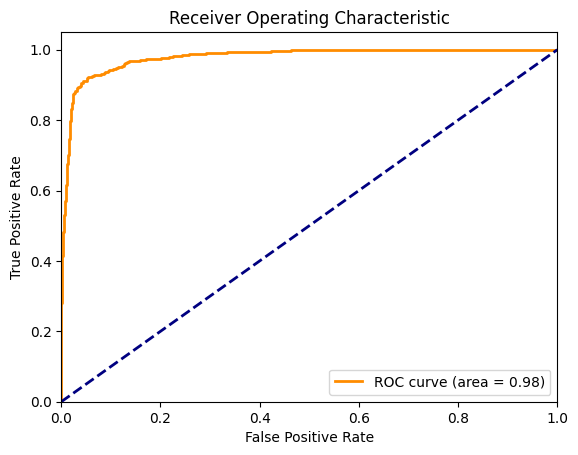

In [13]:
# 11. Visualizar la Curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()